In [1]:
%matplotlib inline

from Bio.Seq import Seq

import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from IPython.display import Image

from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn

from sklearn.metrics import accuracy_score, f1_score

from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm.notebook import tqdm

In [2]:
def top10_accuracy_scorer(gt_idx, top10_idx):

    aciertos = 0

    for arr, gt in zip(top10_idx,gt_idx):
        if gt in arr:
            aciertos+=1
            
    top_10_accuracy =  aciertos / len(gt_idx)
    return top_10_accuracy

In [3]:
def dna_to_protein(sequences):
    seqs = []
    for seq in tqdm(sequences,total=len(sequences)):
        try:
            seqs.append(str(Seq(seq).translate()))
        except e:
            print(e)
            print(seq)
            print('error')
    return seqs

In [4]:
def create_dict(codes):
  char_dict = {}
  for index, val in enumerate(codes):
    char_dict[val] = index + 1

  return char_dict

In [5]:
def integer_encoding(sequences,char_dict):
  encode_list = []
  for row in tqdm(sequences):
    row_encode = []
    for code in row:
      row_encode.append(torch.tensor(char_dict.get(code, 0)))
    encode_list.append(torch.stack(row_encode))
  
  return torch.stack(encode_list)

In [6]:
def _to_one_hot(sequences, num_classes):
    seqs = []
    for y in tqdm(sequences,total=len(sequences)):
        scatter_dim = len(y.size())
        y_tensor = y.view(*y.size(), -1)
        zeros = torch.zeros(*y.size(), num_classes, dtype=y.dtype)
        
        seqs.append(zeros.scatter(scatter_dim, y_tensor, 1))
    return torch.stack(seqs)

In [7]:
def make_plot(training_stats):

    sns.set(style='darkgrid')
    sns.set(font_scale=1.5)

    plt.close()

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Training stats')

    fig.set_size_inches(25, 10)

    ax1.plot(training_stats['train_loss'], 'b-o', label='training')
    ax1.plot(training_stats['dev_loss'], 'b-o', label='validation')

    ax1.set_title("Loss")
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss') 
    ax1.legend()

    ax2.plot(training_stats['train_top10'], 'b-o', label='training')
    ax2.plot(training_stats['dev_top10'], 'b-o', label='validation')

    ax2.set_title("Top 10 Acc")
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Top 10 Acc')
    ax2.legend()

    plt.show() 

In [8]:
train = pd.read_csv('../data/processed/train.csv')
test = pd.read_csv('../data/processed/test.csv')
print('Train: ',train.shape)
print('Test: ',test.shape)

Train:  (67447, 43)
Test:  (18816, 42)


In [9]:
train_protein = dna_to_protein(train.sequence)
test_protein = dna_to_protein(test.sequence)

In [10]:
sequences = train_protein+test_protein
max_len = 0

lenghts = []

for seq in tqdm(sequences,total=len(sequences)):
    l = len(seq)
    max_len = max(max_len, l)
    lenghts.append(l)
    
print(max_len)


20033


<AxesSubplot:>

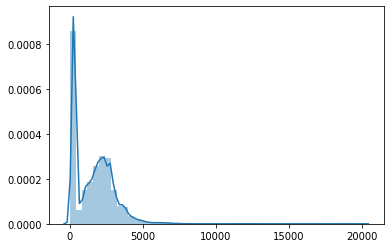

In [11]:
import seaborn as sns 
sns.distplot(lenghts)

In [12]:
np.percentile(lenghts,89)

3118.0

In [13]:
bases = list(set(''.join(train_protein+test_protein)))
print(len(bases))
bases

22


['H',
 'K',
 'S',
 'A',
 'Y',
 'P',
 'G',
 'F',
 'I',
 'R',
 'E',
 '*',
 'N',
 'T',
 'V',
 'Q',
 'C',
 'X',
 'L',
 'W',
 'M',
 'D']

In [14]:
char_dict = create_dict(bases)

print(char_dict)
print("Dict Length:", len(char_dict))

{'H': 1, 'K': 2, 'S': 3, 'A': 4, 'Y': 5, 'P': 6, 'G': 7, 'F': 8, 'I': 9, 'R': 10, 'E': 11, '*': 12, 'N': 13, 'T': 14, 'V': 15, 'Q': 16, 'C': 17, 'X': 18, 'L': 19, 'W': 20, 'M': 21, 'D': 22}
Dict Length: 22


In [15]:
max_len = 3000

train_protein = [x[0:max_len].ljust(max_len, str('000'+x)) for x in train_protein]
test_protein = [x[0:max_len].ljust(max_len, str('000'+x)) for x in test_protein]

char_dict['0'] = 0
char_dict['CLS'] = 1

print(char_dict)
print("Dict Length:", len(char_dict))

{'H': 1, 'K': 2, 'S': 3, 'A': 4, 'Y': 5, 'P': 6, 'G': 7, 'F': 8, 'I': 9, 'R': 10, 'E': 11, '*': 12, 'N': 13, 'T': 14, 'V': 15, 'Q': 16, 'C': 17, 'X': 18, 'L': 19, 'W': 20, 'M': 21, 'D': 22, '0': 0}
Dict Length: 23


In [16]:
X_train = integer_encoding(train_protein,char_dict)
X_test = integer_encoding(test_protein,char_dict)

In [17]:
X = X_train
y = train['target']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1,random_state=420,stratify=y)

In [18]:
labs = pd.read_csv('../data/raw/train_labels.csv').columns[1:]

lab_pos = dict()
i = 0
for lab in labs:
    lab_pos[lab]=i
    i+=1

def get_targets(y):
    targets = []
    for lab in y:
        tmp = np.zeros(len(labs))
        idx = lab_pos[lab]
        tmp[idx] = 1
        targets.append(tmp)
    targets = torch.tensor(targets)
    print(targets.shape)
    return targets

In [19]:
%%time

train_dataset = torch.utils.data.TensorDataset(X_train,get_targets(y_train))

valid_dataset = torch.utils.data.TensorDataset(X_valid,get_targets(y_valid))

test_dataset = torch.utils.data.TensorDataset(X_test)

torch.Size([60702, 1314])
torch.Size([6745, 1314])
Wall time: 11.5 s


In [100]:
bs = 

train_dataloader = torch.utils.data.DataLoader(
    dataset = train_dataset, 
    batch_size = bs, 
    sampler = torch.utils.data.RandomSampler(train_dataset)
)
valid_dataloader = torch.utils.data.DataLoader(
    dataset = valid_dataset, 
    batch_size = bs, 
    sampler = torch.utils.data.RandomSampler(valid_dataset)
)
test_dataloader = torch.utils.data.DataLoader(
    dataset = test_dataset, 
    batch_size = bs, 
    sampler = torch.utils.data.RandomSampler(test_dataset)
)

In [101]:
print(X_train.shape)
print(X_valid.shape)
print(test.shape)

print(y_train.shape)
print(y_valid.shape)

torch.Size([60702, 3000])
torch.Size([6745, 3000])
(18816, 42)
(60702,)
(6745,)


In [102]:
class ResNetBlock(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.conv1 = nn.Conv1d(
            config['hidden_size'], config['hidden_size'], 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(config['hidden_size'])

        self.conv2 = nn.Conv1d(
            config['hidden_size'], config['hidden_size'], 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(config['hidden_size'])

        self.activation_fn = nn.ReLU()

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation_fn(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.activation_fn(out)

        return out

class RedNetBlock(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.conv1 = nn.Conv1d(
            config['hidden_size'], config['hidden_size'],7,stride=2, padding=0, bias=False)
        self.bn1 = nn.BatchNorm1d(config['hidden_size'])

        self.activation_fn = nn.ReLU()

    def forward(self, x):

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation_fn(out)

        return out


class ProteinEmbeddings(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.embeddings = nn.Embedding(config['vocab_size'],config['embed_dim'], padding_idx=0)
        self.bn = nn.BatchNorm1d(config['seq_len'])
        self.dropout = nn.Dropout(config['hidden_dropout_prob'])

    def forward(self, input_ids):
        embeddings = self.embeddings(input_ids)
        embeddings = self.bn(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings


class ResNetEncoder(nn.Module):

    def __init__(self, config):
        super().__init__()
        list_layers = []
        for i in range(config['num_hidden_layers']):
            list_layers.append(ResNetBlock(config))
            list_layers.append(RedNetBlock(config))
        self.layer = nn.ModuleList(list_layers)

    def forward(self, x):

        for layer_module in self.layer:
            x = layer_module(x)

        return x


class cls_head(nn.Module):

    def __init__(self,config):
        super().__init__()

        self.l1 = nn.Linear(config['cls_size'],config['cls_size'])
        self.br_l1 = nn.BatchNorm1d(config['cls_size'])
        self.ac_l1 = nn.LeakyReLU()
        self.dp_l1 = nn.Dropout(0.1)

        self.cls = nn.Linear(config['cls_size'],config['num_labels'])

    def forward(self,x):
        x = self.dp_l1(self.ac_l1(self.br_l1(self.l1(x))))

        return self.cls(x)
        

In [103]:
class Prot_conv(nn.Module):
    # meter cls tok
    def __init__(self):
        super().__init__()

        self.folder = '../models/prot_conv/'

        self.config = dict()

        self.config['vocab_size'] = 23
        self.config['embed_dim'] = 256
        self.config['seq_len'] = 3000
        self.config['num_hidden_layers'] = 2
        self.config['hidden_size'] = 256
        self.config['hidden_act'] = 'gelu'
        self.config['hidden_dropout_prob'] = 0.15
        self.config['layer_norm_eps'] = 1e-12
        self.config['cls_size'] = 256
        self.config['num_labels'] = 1314

        self.embeddings = ProteinEmbeddings(self.config)

        self.resnet = ResNetEncoder(self.config)

        transformer_layer = nn.TransformerEncoderLayer(256, 8, dim_feedforward=512, dropout=0.1, activation='relu')
        self.transformer = nn.TransformerEncoder(transformer_layer, 3, norm=None)
        
        self.classify = cls_head(self.config)

    def forward(self,batch,device):

        input_ids = batch[0].to(device)

        embeddings = self.embeddings(input_ids)
        cls_emb = self.embeddings.embeddings(torch.tensor(0).unsqueeze(0).unsqueeze(0).to(device)).repeat(batch[0].shape[0],1,1)

        x = self.resnet(embeddings.transpose(1,2)).transpose(1,2)

        x = torch.cat((cls_emb,x),dim=1)

        x = self.transformer(x)[:,0,:]
        
        x = self.classify(x)

        return x.cpu()


In [104]:
device = torch.device('cuda')
print(torch.cuda.get_device_name(0))
print(torch.cuda.get_device_properties(0))
model = Prot_conv().to(device)
scaler = torch.cuda.amp.GradScaler()

GeForce GTX 1070 with Max-Q Design
_CudaDeviceProperties(name='GeForce GTX 1070 with Max-Q Design', major=6, minor=1, total_memory=8192MB, multi_processor_count=16)


In [105]:
#model

In [106]:
from topk.svm import SmoothTopkSVM, MaxTopkSVM 
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight

weights = torch.from_numpy(compute_class_weight(class_weight='balanced',classes=labs,y=y))
epochs = 90

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=5,mode='max')

#criterion = torch.nn.BCEWithLogitsLoss(pos_weight=weights)#pos_weight=weights
criterion = MaxTopkSVM (1314,k=10,alpha=1)

folder = model.folder

In [107]:
print('TRAINING...')
epochs = 300
training_stats = []

total_steps = 0

optimizer.zero_grad() 

with tqdm(total=epochs,leave=False) as pbar:
  for epoch_i in range(0, epochs):
    total_train_loss = 0
    model.train()

    #optimizer.zero_grad()
    """
    if epoch_i == 20:
      criterion = MaxTopkSVM(1314,alpha=1,k=10)
    """
    logits = []
    ground_truth = []
    for step, batch in tqdm(enumerate(train_dataloader),total=len(train_dataloader),leave=False):

        optimizer.zero_grad()

        b_labels = batch[1]
        with torch.cuda.amp.autocast(enabled=True):
          b_logits = model(batch,device)
        
        loss = criterion(b_logits.float(),torch.argmax(b_labels.detach(),dim=1)).cuda()
        """
        if epoch_i < 20:
          loss = criterion(b_logits,b_labels.detach()).cuda()
        else:
          loss = criterion(b_logits,torch.argmax(b_labels.detach(),dim=1)).cuda()
        """

        scaler.scale(loss).backward()
        total_train_loss += loss.item()
        
        logits.extend(b_logits.detach().numpy())
        ground_truth.extend(np.argmax(b_labels.detach().numpy(),axis=1))    

        scaler.step(optimizer)
        scaler.update()
        total_steps+=1

    y_top10_idx = np.argpartition(logits, -10, axis=1)[:, -10:]
    y_labels = np.argmax(logits,axis=1)

    train_top10 = top10_accuracy_scorer(ground_truth,y_top10_idx)
    train_acc = round(metrics.accuracy_score(ground_truth,y_labels),3)
    avg_train_loss = total_train_loss/len(train_dataloader)

    model.eval()

    total_dev_loss = 0

    logits = []
    ground_truth = []
            
    for step, batch in enumerate(valid_dataloader):

        inputs = batch[0].to(device)
    
        b_labels = batch[1]
        with torch.cuda.amp.autocast(enabled=True):
          with torch.no_grad():
            b_logits = model(batch,device)
        loss = criterion(b_logits.float(),torch.argmax(b_labels.detach(),dim=1)).cuda()
        """
        if epoch_i < 20:
          loss = criterion(b_logits,b_labels.detach()).cuda()
        else:
          loss = criterion(b_logits,torch.argmax(b_labels.detach(),dim=1)).cuda()
        """
        scaler.scale(loss)
        total_dev_loss += loss.item()

        logits.extend(b_logits.float().detach().numpy())
        ground_truth.extend(np.argmax(b_labels.detach().numpy(),axis=1))


    y_top10_idx = np.argpartition(logits, -10, axis=1)[:, -10:]
    y_labels = np.argmax(logits,axis=1)

    test_top10 = top10_accuracy_scorer(ground_truth,y_top10_idx)
    test_acc = round(metrics.accuracy_score(ground_truth,y_labels),3)
    avg_dev_loss = total_dev_loss/len(valid_dataloader)

    scheduler.step(test_top10)
 
    training_stats.append(
        {
            'train_loss': avg_train_loss,
            'dev_loss': avg_dev_loss,
            'train_acc': train_acc,
            'train_top10':train_top10,
            'dev_acc': test_acc,
            'dev_top10': test_top10
        }
      )
    
    torch.save(model,folder+str(epoch_i)+'.ckpt')
    
    pbar.update(1)

    print('\nEpoch: ',epoch_i,' train_loss ',avg_train_loss,
            ' dev_loss ',avg_dev_loss,
            ' train acc ',train_acc,
            ' train_top10 ',train_top10,
            ' dev_acc ',test_acc,
            ' dev_top10 ', test_top10
          )

# Show training results
col_names = ['train_loss','train_acc','train_top10','dev_loss', 'dev_acc','dev_top10']
training_stats = pd.DataFrame(training_stats,columns=col_names)
make_plot(training_stats)

TRAINING...



Epoch:  0  train_loss  0.8251121882928568  dev_loss  0.7836219332229469  train acc  0.114  train_top10  0.22948173042074396  dev_acc  0.123  dev_top10  0.2357301704966642


KeyboardInterrupt: 

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()